In [3]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

Paths defined in paths module:
 paths.mii_home: /Users/trafferty/dev
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.results_root: /Users/trafferty/data/results
 paths.projects_root: /Users/trafferty/data/projects
 paths.tmp_dir: /Users/trafferty/tmp
 paths.inhouse: /Users/trafferty/dev/inhouse
 paths.ws_dir: /Users/trafferty/workspace
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.tmp_root: /Users/trafferty/data/tmp


### Read in an image, some anotation, plotting

In [60]:
cb_DIF2_path=paths.images_root+'/dif/DIF2_calibration_images/checkerboard_2.tif'
DIF2_img1_path = paths.images_root+'/dif/DIF2_OCE_images/DIFCapture_01.tif'
cb1_path=paths.images_root+'/checkerboard1.png'
cb_normal_path=paths.images_root+'/checkerboard_normal.png'
cb_barrel_path=paths.images_root+'/checkerboard_barrel.png'
cb_pincushion_path=paths.images_root+'/checkerboard_pincushion.png'

cb_normal = cv2.imread(cb_normal_path,cv2.IMREAD_GRAYSCALE)
cb_barrel = cv2.imread(cb_barrel_path,cv2.IMREAD_GRAYSCALE)
cb_pincushion = cv2.imread(cb_pincushion_path,cv2.IMREAD_GRAYSCALE)

circGrid_path = paths.images_root+'/circle_grid.jpg'
circGrid_DIF2_path = paths.images_root+'/dif/DIF2_calibration_images/62.5 um circle_mid.tif'

#default_path = cb_DIF2_path
default_path = circGrid_DIF2_path


# Scale 16-bit image to 8-bit
def convert16BitTo8Bit(img16):
    # Scale ref to 8-bit
    minLevel = np.min(np.min(img16))
    img8 = (img16 - minLevel);
    maxLevel = np.max(np.max(img8))
    img8 = (img8*255.0/maxLevel).astype(np.uint8)
    return img8

def read_image(top=True):
    cb_img = cv2.imread(default_path,cv2.IMREAD_GRAYSCALE)
    rows, cols = cb_img.shape
    midX, midY = int(cols/2), int(rows/2)
    if top:
        imgSlice = cb_img[0:midY, 0:cols] #np slice: [startY:endY, startX:endX]
    else:
        imgSlice = cb_img[midY+1:rows, 0:cols]
    return convert16BitTo8Bit(imgSlice)  

def subimage2(image, center, theta, width, height):
    #theta = np.deg2rad(theta)

    v_x = (np.cos(theta), np.sin(theta))
    v_y = (-np.sin(theta), np.cos(theta))
    s_x = center[0] - v_x[0] * (width / 2) - v_y[0] * (height / 2)
    s_y = center[1] - v_x[1] * (width / 2) - v_y[1] * (height / 2)

    mapping = np.array([[v_x[0],v_y[0], s_x],
                        [v_x[1],v_y[1], s_y]])

    return cv2.warpAffine(image,mapping,(width, height),flags=cv2.WARP_INVERSE_MAP,borderMode=cv2.BORDER_REPLICATE)

# img = cv2.imread('../images/owl.jpg', -1)
# print( img.shape)
# patch = subimage2(img, (110, 125), np.pi / 6.0, 100, 200)


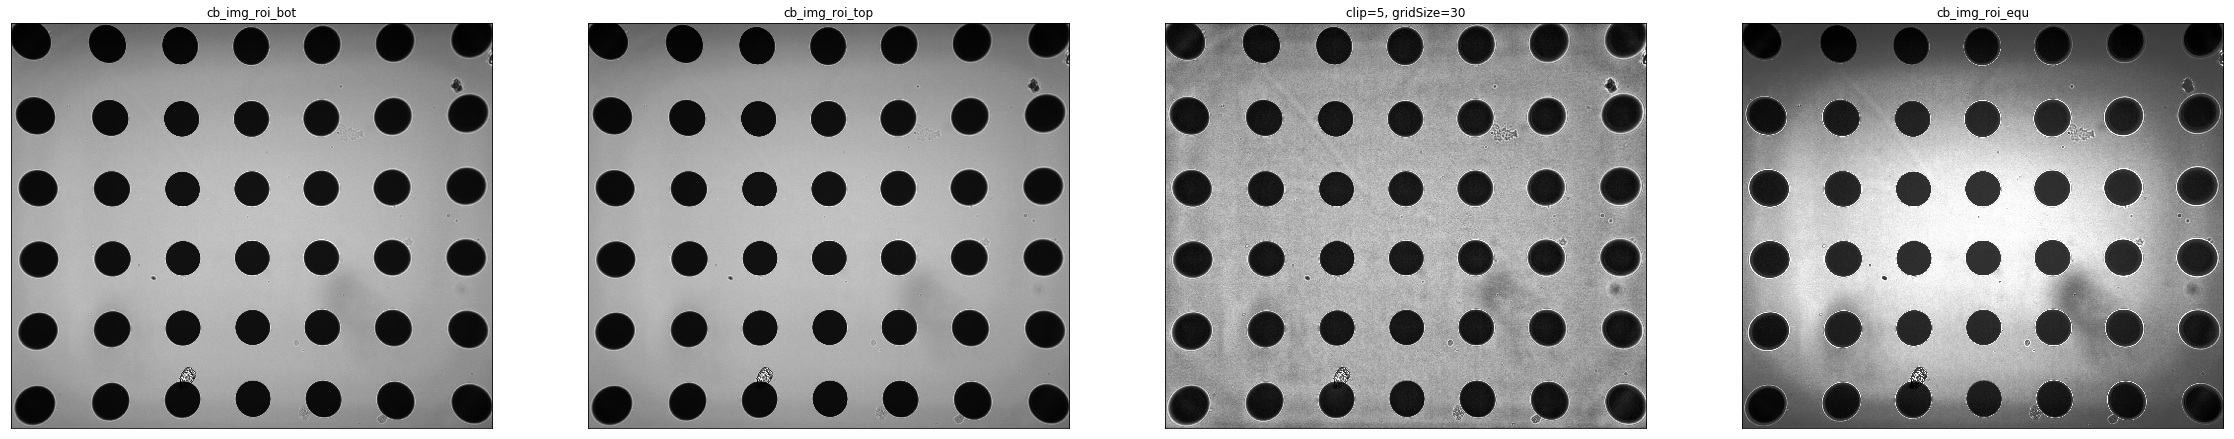

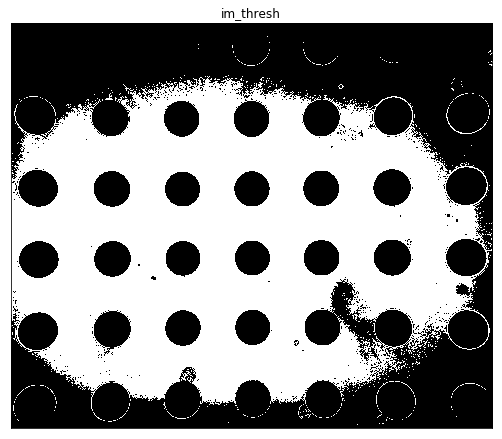

In [14]:
plot_list = []

cb_img_roi_bot = read_image(False)
plot_list.append((cb_img_roi_bot, "cb_img_roi_bot"))
cb_img_roi = read_image(False)
plot_list.append((cb_img_roi, "cb_img_roi_top"))

# gauBlur1 = cv2.GaussianBlur(cb_img_roi,(3,3),0)
# gauBlur2 = cv2.GaussianBlur(cb_img_roi,(11,11),0)
# diffOfGau = gauBlur1-gauBlur2
# dog_med = cv2.medianBlur(diffOfGau, 5, 0)
# cb_img_roi_equ = cv2.equalizeHist(cb_img_roi)
# ret, im_thresh = cv2.threshold(cb_img_roi_equ,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

clipLimit=5
gridSize = 30

clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(gridSize,gridSize))
cl1 = clahe.apply(cb_img_roi)
plot_list.append((cl1, "clip=%d, gridSize=%d" % (clipLimit, gridSize)))
#cb_img_roi_equ = cv2.equalizeHist(cl1)

# gauBlur1 = cv2.GaussianBlur(cl1,(3,3),0)
# plot_list.append((gauBlur1, "gauBlur1"))
# gauBlur2 = cv2.GaussianBlur(cb_img_roi,(11,11),0)
# plot_list.append((gauBlur2, "gauBlur2"))
# diffOfGau = gauBlur1-gauBlur2
# plot_list.append((diffOfGau, "diffOfGau"))
# dog_med = cv2.medianBlur(diffOfGau, 5, 0)
# plot_list.append((dog_med, "dog_med"))
cb_img_roi_equ = cv2.equalizeHist(cb_img_roi)
plot_list.append((cb_img_roi_equ, "cb_img_roi_equ"))
ret, im_thresh = cv2.threshold(cb_img_roi_equ,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plot_list.append((im_thresh, "im_thresh"))



#util.plot_imgs([(cb_img_roi,'cb_img_roi'), (cl1,'cl1'), (cb_img_roi_equ,'cb_img_roi_equ')], max_cols = 4)
util.plot_imgs(plot_list, max_cols = 4)

In [ ]:
plot_list = []

for clipLimit in range(1, 50, 5):
    for gridSize in range(1, 100, 10):
        cb_img_roi = read_image()

        # gauBlur1 = cv2.GaussianBlur(cb_img_roi,(3,3),0)
        # gauBlur2 = cv2.GaussianBlur(cb_img_roi,(11,11),0)
        # diffOfGau = gauBlur1-gauBlur2
        # dog_med = cv2.medianBlur(diffOfGau, 5, 0)
        # cb_img_roi_equ = cv2.equalizeHist(cb_img_roi)
        # ret, im_thresh = cv2.threshold(cb_img_roi_equ,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(gridSize,gridSize))
        cl1 = clahe.apply(cb_img_roi)
        plot_list.append((cl1, "clip=%d, gridSize=%d" % (clipLimit, gridSize)))
        #cb_img_roi_equ = cv2.equalizeHist(cl1)

#util.plot_imgs([(cb_img_roi,'cb_img_roi'), (cl1,'cl1'), (cb_img_roi_equ,'cb_img_roi_equ')], max_cols = 4)
util.plot_imgs(plot_list, max_cols = 4)

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


In [ ]:
cb_img_roi = gauBlur2
patternSize = (40,34)

rows, cols = cb_img_roi.shape
midX, midY = int(cols/2), int(rows/2)

#flags= cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK 
flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FILTER_QUADS
#flags= cv2.CALIB_CB_FAST_CHECK

print("Trying with pattern: (%d, %d)" % (patternSize[0], patternSize[1]))

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(cb_img_roi, patternSize, flags)

# If found, add object points, image points (after refining them)
if ret == True:
    print(" > Found it with pattern: (%d, %d)" % (patternSize[0], patternSize[1]))
else:
    print("Not Found...")


In [ ]:
cb_img_roi = gauBlur2
patternSize = (34,40)

rows, cols = cb_img_roi.shape
midX, midY = int(cols/2), int(rows/2)

flags= cv2.CALIB_CB_FAST_CHECK

for r in range(33,38):
    for c in range(38,42):
        patternSize = (r,c)
        print("Trying with pattern: (%d, %d)" % (patternSize[0], patternSize[1]))
              
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(cb_img_roi, patternSize, flags)

        # If found, add object points, image points (after refining them)
        if ret == True:
            print(" > Found it with pattern: (%d, %d)" % (patternSize[0], patternSize[1]))
        #     objpoints.append(objp)

        #     corners2 = cv2.cornerSubPix(cb_img_roi, corners,(11,11),(-1,-1),criteria)
        #     imgpoints.append(corners2)

        #     # Draw and display the corners
        #     cb_img2 = cv2.drawChessboardCorners(cb_img_rotated, patternSize, corners2,ret)

        #     util.plot_imgs([(cb_img2,'checkerboard')], max_cols = 2)
        else:
            print("Not Found...")


In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cb_img_rotated.shape[::-1],None,None)


In [ ]:
h,  w = cb_img_rotated.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

In [ ]:
cb_img_in = read_image()
cb_img_raw = cv2.imread(cb_barrel_path,cv2.IMREAD_GRAYSCALE)


# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(cb_img_raw, mapx, mapy, cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
cb_img_fixed = dst[y:y+h, x:x+w]

util.plot_imgs([(cb_img_raw,'cb_img_raw'), (cb_img_fixed,'cb_img_fixed'), (cb_normal,'cb_normal')], max_cols = 3)

In [ ]:
idx = 1
DIF2_path = paths.images_root+'/dif/DIF2_OCE_images/DIFCapture_0%d.tif' % (idx)

dif_img_raw = cv2.imread(DIF2_path, cv2.IMREAD_GRAYSCALE)
rows, cols = dif_img_raw.shape
midX, midY = int(cols/2), int(rows/2)
print(rows/2)

dif_img = dif_img_raw[1:int(rows/2), 1:cols]  #np slice: [startY:endY, startX:endX]

util.plot_imgs([(dif_img,'dif_img')], max_cols = 3)

In [ ]:
rows, cols = dif_img.shape

cb_barrel = cv2.imread(cb_barrel_path,cv2.IMREAD_GRAYSCALE)
cb_barrel_rotate = imutils.rotate_bound(cb_barrel, 90)
cb_barrel_large = cv2.resize(cb_barrel_rotate, (cols, rows))

for img in [dif_img, cb_barrel, cb_barrel_large]:
    print("(%d, %d)" % (img.shape[0], img.shape[1]))
    
util.plot_imgs([(cb_barrel,'cb_barrel'), (cb_barrel_rotate,'cb_barrel_rotate'), (cb_barrel_large,'cb_barrel_large')], max_cols = 3)

In [ ]:
cb_img = cb_barrel_large

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(cb_img, (7,7), None)

# If found, add object points, image points (after refining them)
if ret == True:
    objpoints.append(objp)

    corners2 = cv2.cornerSubPix(cb_img, corners,(11,11),(-1,-1),criteria)
    imgpoints.append(corners2)

    # Draw and display the corners
    cb_img2 = cv2.drawChessboardCorners(cb_img, (7,7), corners2,ret)

    util.plot_imgs([(cb_img2,'checkerboard')], max_cols = 2)
else:
    print("Not Found...")


In [ ]:
# undistort
dst = cv2.remap(dif_img, mapx, mapy, cv2.INTER_LINEAR)

# # crop the image
# x,y,w,h = roi
# cb_img_fixed = dst[y:y+h, x:x+w]

util.plot_imgs([(dif_img,'dif_img'), (dst,'dif_img')], max_cols = 3)

### Okay, lets try findCircleGrid...

- https://longervision.github.io/2017/03/13/opencv-external-posture-estimation-circle-grid/
- https://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=findchessboardcorners#findcirclesgrid


uint8
rows: 2159, cols: 2560
img_bot        - rows: 2159, cols: 2560
img_bot_border - rows: 2373, cols: 2816


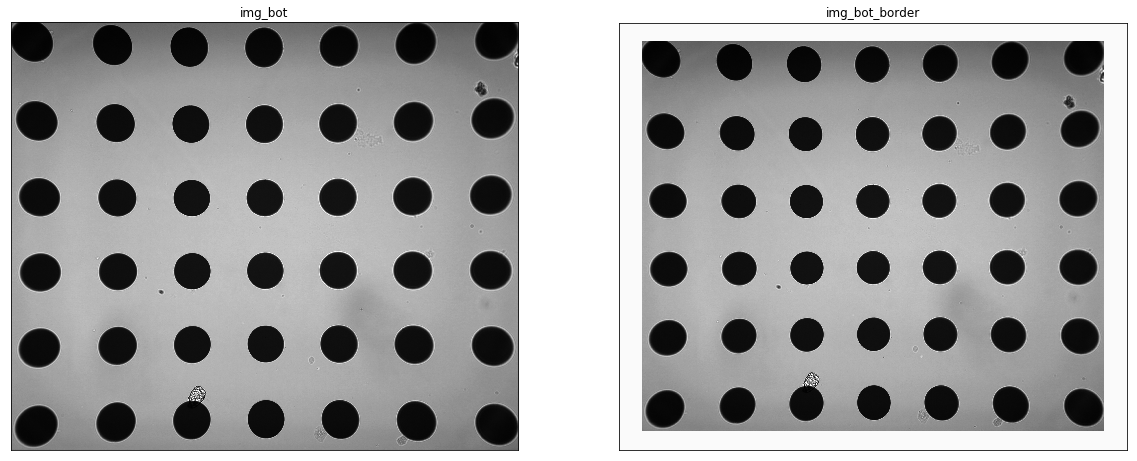

In [44]:
img_bot = read_image(False)
print(img_bot.dtype)
circGrid = cv2.imread(circGrid_path,cv2.IMREAD_GRAYSCALE)

rows, cols = img_bot.shape
print("rows: %d, cols: %d" % (rows,cols))
midX, midY = int(cols/2), int(rows/2)

# img_bot_roi = img_bot[midY-1000:midY+1000, midX-1150:midX+1150] #np slice: [startY:endY, startX:endX]
# rows, cols = img_bot_roi.shape
# print("rows: %d, cols: %d" % (rows,cols))

# # img = np.ones(img_bot_roi.shape, np.uint8)*255

# # Draw a white, filled rectangle on the mask image
# cv2.rectangle(img_bot_roi, (0,0), (200, rows), (255, 0, 255), -1)    # upper-left and lower-right corners (X, Y)
# cv2.rectangle(img_bot_roi, (0,0), (cols,200), (255, 255, 255), -1)
# cv2.rectangle(img_bot_roi, (cols-200, rows), (cols, 0), (255, 255, 255), -1)
# cv2.rectangle(img_bot_roi, (0, rows-200), (cols, rows), (255, 255, 255), -1)

top = int(0.05 * img_bot.shape[0])  # shape[0] = rows
bottom = top
left = int(0.05 * img_bot.shape[1])  # shape[1] = cols
right = left
borderType = cv2.BORDER_CONSTANT

value = [250, 250, 250]
img_bot_border = cv2.copyMakeBorder(img_bot, top, bottom, left, right, borderType, None, value)

print("img_bot        - rows: %d, cols: %d" % (img_bot.shape[0],img_bot.shape[1]))
print("img_bot_border - rows: %d, cols: %d" % (img_bot_border.shape[0],img_bot_border.shape[1]))


util.plot_imgs([(img_bot,'img_bot'), (img_bot_border,'img_bot_border')], max_cols = 3)

[findROI] num keypoints found:  42
[findROI] (255, 2145), dia: 209, area: 656.592865
[findROI] (1025, 232), dia: 194, area: 609.468975
[findROI] (1779, 227), dia: 197, area: 618.893753
[findROI] (639, 222), dia: 200, area: 628.318531
[findROI] (2167, 212), dia: 203, area: 637.743309
[findROI] (2575, 192), dia: 210, area: 659.734457
[findROI] (232, 202), dia: 209, area: 656.592865
[findROI] (2575, 2137), dia: 211, area: 662.876050
[findROI] (657, 2125), dia: 199, area: 625.176938
[findROI] (2170, 2120), dia: 200, area: 628.318531
[findROI] (1787, 2111), dia: 193, area: 606.327382
[findROI] (1413, 2110), dia: 189, area: 593.761012
[findROI] (1040, 2108), dia: 210, area: 659.734457
[findROI] (270, 1750), dia: 203, area: 637.743309
[findROI] (2555, 1741), dia: 203, area: 637.743309
[findROI] (664, 1740), dia: 193, area: 606.327382
[findROI] (2158, 1734), dia: 195, area: 612.610567
[findROI] (1780, 1730), dia: 190, area: 596.902604
[findROI] (1041, 1733), dia: 187, area: 587.477826
[findROI

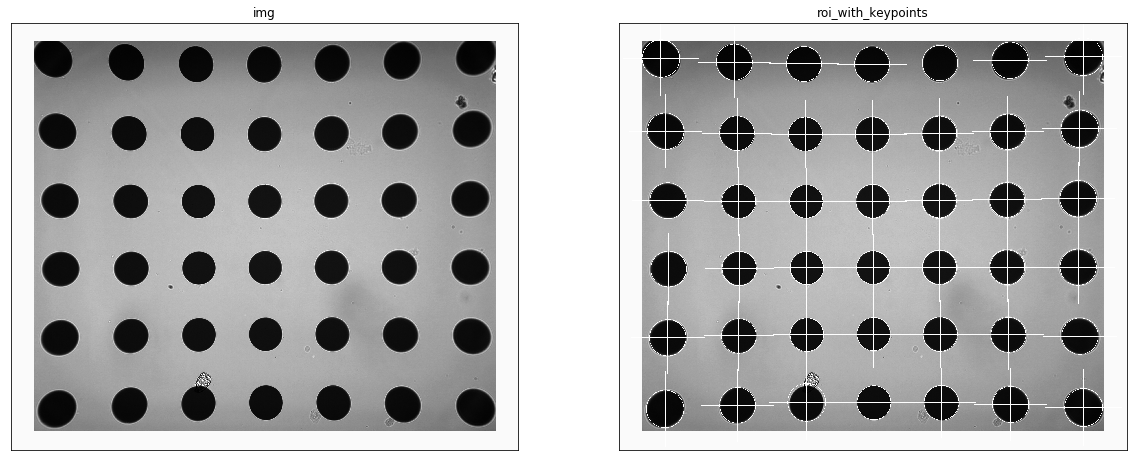

In [45]:
def createDetector():
#     # Setup SimpleBlobDetector parameters.
#     params = cv2.SimpleBlobDetector_Params()

#     # Change thresholds
#     params.minThreshold = 8 #20;
#     params.maxThreshold = 255 #35

#     # Filter by Circularity
#     params.filterByCircularity = True
#     params.minCircularity = .8

#     # # Filter by Convexity
#     params.filterByConvexity = False
#     # params.minConvexity = 0.87

#     # # Filter by Inertia
#     params.filterByInertia = False
#     # params.minInertiaRatio = 0.9

#     params.filterByColor = True
#     params.blobColor = 0
    
#     params.filterByArea = True
# #     params.minArea = 4 * np.pi
# #     params.maxArea = 100 * np.pi
#     params.minArea = 10
#     params.maxArea = 500

    blobParams = cv2.SimpleBlobDetector_Params()
    # Change thresholds
    blobParams.minThreshold = 8
    blobParams.maxThreshold = 255

    # Filter by Area.
    blobParams.filterByArea = True
    blobParams.minArea = 20000     # minArea may be adjusted to suit for your experiment
    blobParams.maxArea = 40000   # maxArea may be adjusted to suit for your experiment

    # Filter by Circularity
    blobParams.filterByCircularity = False
    blobParams.minCircularity = 0.1

    # Filter by Convexity
    blobParams.filterByConvexity = True
    blobParams.minConvexity = 0.87

    # Filter by Inertia
    blobParams.filterByInertia = True
    blobParams.minInertiaRatio = 0.01

    blobParams.filterByColor = True
    blobParams.blobColor = 0
    
    # Create the iteration criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)    
    
    return cv2.SimpleBlobDetector_create(blobParams)

def findBLOBs(img):

    detector = createDetector()
    #detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(img)
    return keypoints

# img = img_bot_roi
img = img_bot_border

keypoints = findBLOBs(img)
print( "[findROI] num keypoints found: ", len(keypoints))

drawSelf = True
if len(keypoints) > 0:

    if drawSelf:
        roi_with_keypoints = img.copy()
        for idx, kp in enumerate(keypoints):
            x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
            if dia < 100 or dia > 250:
                print("Skipping #%d: dia = %d" % (idx, dia))
                continue

            #print(kp.size)
            print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))

            cv2.circle(roi_with_keypoints, (x, y), int(dia/2), (255,255,255),2)
            cv2.line(roi_with_keypoints, (x, y-dia), (x, y+dia), (255,255,255), 3)
            cv2.line(roi_with_keypoints, (x-dia, y), (x+dia, y), (255,255,255), 3)
            
    else:
        # Draw detected blobs as red circles.
        # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
        roi_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


    util.plot_imgs([(img,'img'), (roi_with_keypoints,'roi_with_keypoints')], max_cols = 3)

In [51]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*6,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


 > Found it with pattern: (6, 7)


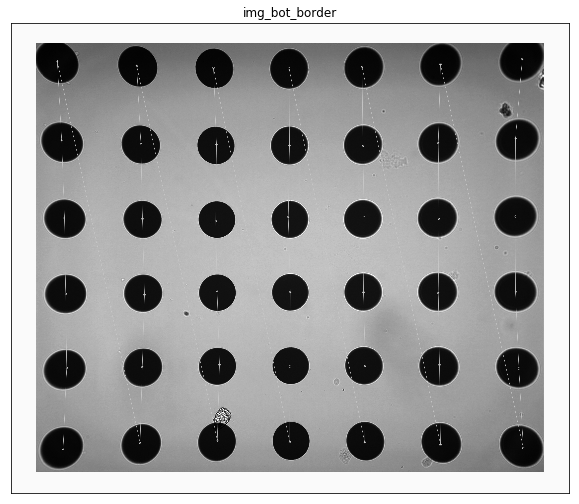

In [52]:
patternSize = (6,7)

flags = None
flags = cv2.CALIB_CB_SYMMETRIC_GRID + cv2.CALIB_CB_CLUSTERING
#flags = cv2.CALIB_CB_SYMMETRIC_GRID

retval, centers = cv2.findCirclesGrid(img_bot_border, patternSize, None, flags, createDetector())

#     im_with_keypoints_gray = cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2GRAY)
#     retval, corners = cv2.findCirclesGrid(im_with_keypoints, (4,11), None, flags = cv2.CALIB_CB_ASYMMETRIC_GRID)   # Find the circle grid


# If found, add object points, image points (after refining them)
if retval == True:
    print(" > Found it with pattern: (%d, %d)" % (patternSize[0], patternSize[1]))
    
    objpoints.append(objp)
    
    centers2 = cv2.cornerSubPix(img_bot_border, centers,(11,11),(-1,-1),criteria)
    imgpoints.append(centers2)

    img2 = img_bot_border.copy()
    cv2.drawChessboardCorners(img2, patternSize, centers2, retval);
    
    util.plot_imgs([(img2,'img_bot_border')])
else:
    print("Not Found...")

In [54]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_bot_border.shape[::-1],None,None)
print(ret)

6.719992257693138


In [56]:
h,  w = img_bot_border.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
newcameramtx

array([[  2.12863926e+04,   0.00000000e+00,   1.40675446e+03],
       [  0.00000000e+00,   2.08575645e+04,   1.22177583e+03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

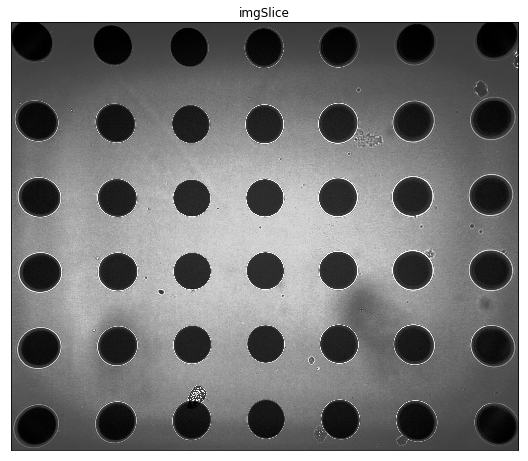

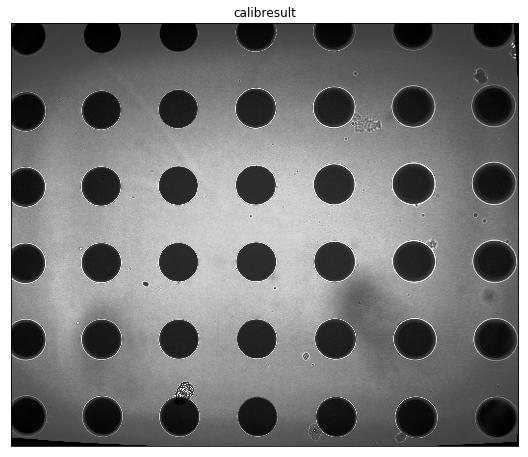

In [67]:
p = circGrid_DIF2_path
#p = DIF2_img1_path
img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
img_equ = cv2.equalizeHist(img)
rows, cols = img.shape
midX, midY = int(cols/2), int(rows/2)
imgSlice = img_equ[midY+1:rows, 0:cols]
img8 = convert16BitTo8Bit(imgSlice)  

# undistort
dst = cv2.undistort(img8, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
util.plot_imgs([(imgSlice,'imgSlice'), (dst,'calibresult')], max_cols = 1)

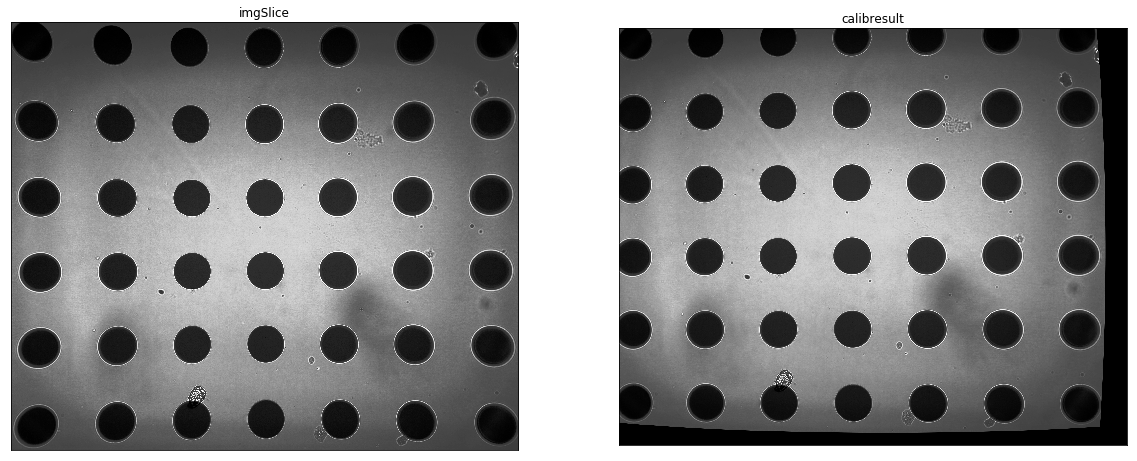

In [68]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst2 = cv2.remap(img8,mapx,mapy,cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst2 = dst2[y:y+h, x:x+w]
util.plot_imgs([(imgSlice,'imgSlice'), (dst2,'calibresult')], max_cols = 2)